# 기술적투자

## 볼린저 밴드 
- 평균회귀전략 구현 

### 볼린저밴드 구현 

In [324]:
df = pd.read_csv('./data/2016krx데이터_시총_상장주식수_수정종가추가본/000180',index_col=0,parse_dates=True)
df.head()

,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,상장주식수,수정종가
2016-01-04,33000,34000,32200,32450,60185,1990610250,1.72,180,226343942000,6975160,3245
2016-01-05,33000,34300,32450,32850,41680,1378997450,1.23,180,229134006000,6975160,3285
2016-01-06,33200,33350,32500,33050,22417,734090200,0.61,180,230529038000,6975160,3305
2016-01-07,32900,33550,32400,32400,30705,1005939550,-1.97,180,225995184000,6975160,3240
2016-01-08,31900,32200,31350,31800,34036,1076454850,-1.85,180,221810088000,6975160,3180


In [325]:
df.describe()

,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,상장주식수,수정종가
count,1572.000000,1572.000000,1572.000000,1572.000000,1.572000e+03,1.572000e+03,1572.000000,1572.0,1.572000e+03,1.572000e+03,1572.000000
mean,4089.310433,4179.166667,4000.299618,4444.977735,5.144142e+05,1.619608e+09,0.014065,180.0,1.770457e+11,6.635720e+07,2538.231552
std,7797.040103,8032.358122,7553.594593,8380.419190,1.796501e+06,5.193083e+09,2.484793,0.0,4.657333e+10,1.420193e+07,667.702691
min,0.000000,0.000000,0.000000,1000.000000,0.000000e+00,0.000000e+00,-24.810000,180.0,6.975160e+10,6.975160e+06,1000.000000
25%,1980.000000,2005.000000,1950.000000,1993.750000,9.123700e+04,2.142810e+08,-0.950000,180.0,1.390673e+11,6.975160e+07,1993.750000
50%,2595.000000,2630.000000,2555.000000,2605.000000,1.688920e+05,4.699725e+08,0.000000,180.0,1.817029e+11,6.975160e+07,2605.000000
75%,2990.000000,3030.000000,2950.000000,3000.000000,3.737778e+05,1.180477e+09,0.950000,180.0,2.092548e+11,6.975160e+07,3000.000000
max,51300.000000,52500.000000,49650.000000,51600.000000,4.479404e+07,9.385736e+10,29.870000,180.0,3.599183e+11,6.975160e+07,5160.000000


In [326]:
df = df.rename(columns={'Adj Close':'수정종가'})

In [327]:
# 볼린저 밴드 데이터 프렝미에 필요한 변수만 선택

In [328]:
price_df = pd.DataFrame(df.loc[:,'수정종가'].copy())
price_df.head()

,수정종가
2016-01-04,3245
2016-01-05,3285
2016-01-06,3305
2016-01-07,3240
2016-01-08,3180


In [329]:
n = 20 
sigma = 2
def bollinger_band(price_df,n,sigma):
    bb = price_df.copy()
    bb['center'] = price_df['수정종가'].rolling(n).mean()
    bb['ub'] = bb['center'] + sigma * price_df['수정종가'].rolling(n).std()
    bb['lb'] = bb['center'] - sigma * price_df['수정종가'].rolling(n).std()
    return bb 

bollinger = bollinger_band(price_df, n, sigma)
      

In [330]:
base_date = '2009-01-02'
sample = bollinger.loc[base_date:]
sample.head()
# 쿠션데이터 확보 

,수정종가,center,ub,lb
2016-01-04,3245,NaN,NaN,NaN
2016-01-05,3285,NaN,NaN,NaN
2016-01-06,3305,NaN,NaN,NaN
2016-01-07,3240,NaN,NaN,NaN
2016-01-08,3180,NaN,NaN,NaN


In [331]:
def create_trade_book(sample):
    book = sample[['수정종가']].copy()
    book['trade'] = ''
    return (book)

In [332]:
book = create_trade_book(sample)
book

,수정종가,trade
2016-01-04,3245,
2016-01-05,3285,
2016-01-06,3305,
2016-01-07,3240,
2016-01-08,3180,
...,...,...
2022-05-19,2595,
2022-05-20,2605,
2022-05-23,2510,
2022-05-24,2420,


In [333]:
def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, '수정종가'] > sample.loc[i, 'ub']: # 상단밴드 이탈시 동작 안함
            book.loc[i, 'trade'] = ''
        elif sample.loc[i, 'lb'] > sample.loc[i, '수정종가']: # 하반밴드 이탈시 매수
            if book.shift(1).loc[i, 'trade'] == 'buy':    # 이미 매수상태라면
                book.loc[i, 'trade'] = 'buy'     # 매수상태 유지
            else:
                book.loc[i, 'trade'] = 'buy'    
        elif sample.loc[i, 'ub'] >= sample.loc[i, '수정종가'] and sample.loc[i, '수정종가'] >= sample.loc[i, 'lb']: # 볼린저 밴드 안에 있을 시
            if book.shift(1).loc[i, 'trade'] == 'buy':
                book.loc[i, 'trade'] = 'buy'  # 매수상태 유지
            else:
                book.loc[i, 'trade'] = '' # 동작 안함
    return (book) 

In [334]:
tradings(sample,book)

,수정종가,trade
2016-01-04,3245,
2016-01-05,3285,
2016-01-06,3305,
2016-01-07,3240,
2016-01-08,3180,
...,...,...
2022-05-19,2595,
2022-05-20,2605,
2022-05-23,2510,
2022-05-24,2420,buy


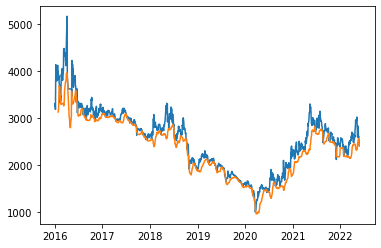

In [335]:
plt.plot(sample[['수정종가','lb']])

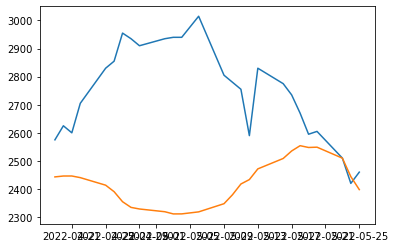

In [336]:
plt.plot(sample.loc['2022-04-19':,['수정종가','lb']])

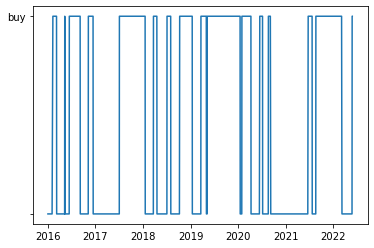

In [337]:
plt.plot(book['trade'])

### 볼린저밴드 수익률 구현 

In [338]:
def returns(book):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy' and book.shift(1).loc[i, 'trade'] == '':     # long 진입
            buy = book.loc[i, '수정종가']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy':     # long 청산
            sell = book.loc[i, '수정종가']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))
    
        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
    
    acc_rtn = 1.0
    for i in book.index:
        rtn = book.loc[i, 'return']
        acc_rtn = acc_rtn * rtn  # 누적 수익률 계산
        book.loc[i, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [339]:
returns(book)

진입일 :  2016-02-11 00:00:00 long 진입가격 :  3650
청산일 :  2016-03-11 00:00:00 long 진입가격 :  3650  |  long 청산가격 :  4450  | return: 1.2192
진입일 :  2016-05-12 00:00:00 long 진입가격 :  3460
청산일 :  2016-05-13 00:00:00 long 진입가격 :  3460  |  long 청산가격 :  4220  | return: 1.2197
진입일 :  2016-06-16 00:00:00 long 진입가격 :  3330
청산일 :  2016-09-08 00:00:00 long 진입가격 :  3330  |  long 청산가격 :  3260  | return: 0.979
진입일 :  2016-11-09 00:00:00 long 진입가격 :  2930
청산일 :  2016-12-16 00:00:00 long 진입가격 :  2930  |  long 청산가격 :  3285  | return: 1.1212
진입일 :  2017-07-05 00:00:00 long 진입가격 :  3055
청산일 :  2018-01-19 00:00:00 long 진입가격 :  3055  |  long 청산가격 :  2710  | return: 0.8871
진입일 :  2018-03-23 00:00:00 long 진입가격 :  2670
청산일 :  2018-04-19 00:00:00 long 진입가격 :  2670  |  long 청산가격 :  2850  | return: 1.0674
진입일 :  2018-07-05 00:00:00 long 진입가격 :  2650
청산일 :  2018-08-03 00:00:00 long 진입가격 :  2650  |  long 청산가격 :  2715  | return: 1.0245
진입일 :  2018-10-10 00:00:00 long 진입가격 :  2470
청산일 :  2019-01-15 00:00:00 long 진입가격 :  2470  

1.4234

<AxesSubplot:>

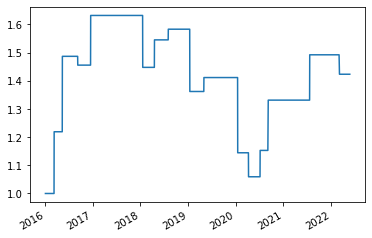

In [340]:
book['acc return'].plot()

## 듀얼 모멘텀 전략 
- 위험을 관리하는 투자전략
- 절대 모멘텀 전략: 최근N개월간 수익률이 양수면 매수, 음수면 공매도
- 상대 모멘텀 전략: 10개종목(주관)이 최근 N개월 모멘텀을 계산하고 모멘텀이 높은 종목을 매수, 낮은종목을 공매도 
    - 계산된 상대 모멘텀 지수를 갖고 종목을 필터링 하며 몇% 종목을 대상으로 할지는 백테스팅을 통해 최적의 성과를 나타내는 매겨변수를 찾아 결정함.

### 듀얼 모멘텀 전략 구현을 위한 절대 모멘텀 전략
- 과거 12개월간 종가의 수익률을 절대모멘텀지수로 계산, 주가변동이 0% 이상이면 매수신호 발생, 0% 미만이면 매도신호가 발생 
- 다수종목을 대상으로 구현할 수도 있음 
 

In [341]:
import datetime

In [352]:
df = pd.read_csv('./data/2016krx데이터_시총_상장주식수_수정종가추가본/000020')
df.head()

,Unnamed: 0,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,상장주식수,수정종가
0,2016-01-04,8130,8150,7920,8140,281440,2265829150,0.00,20,227362165800,27931470,8140
1,2016-01-05,8040,8250,8000,8190,243179,1981977230,0.61,20,228758739300,27931470,8190
2,2016-01-06,8200,8590,8110,8550,609906,5129946490,4.40,20,238814068500,27931470,8550
3,2016-01-07,8470,8690,8190,8380,704752,5919556330,-1.99,20,234065718600,27931470,8380
4,2016-01-08,8210,8900,8130,8770,802330,6875778520,4.65,20,244958991900,27931470,8770


In [353]:
df = df.rename(columns= {'Unnamed: 0':'Date'})
df.head()

,Date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,상장주식수,수정종가
0,2016-01-04,8130,8150,7920,8140,281440,2265829150,0.00,20,227362165800,27931470,8140
1,2016-01-05,8040,8250,8000,8190,243179,1981977230,0.61,20,228758739300,27931470,8190
2,2016-01-06,8200,8590,8110,8550,609906,5129946490,4.40,20,238814068500,27931470,8550
3,2016-01-07,8470,8690,8190,8380,704752,5919556330,-1.99,20,234065718600,27931470,8380
4,2016-01-08,8210,8900,8130,8770,802330,6875778520,4.65,20,244958991900,27931470,8770


In [354]:
price_df = df[['Date','수정종가']]
price_df.head()

,Date,수정종가
0,2016-01-04,8140
1,2016-01-05,8190
2,2016-01-06,8550
3,2016-01-07,8380
4,2016-01-08,8770


In [355]:
# 월말데이터 사용 
price_df['월말'] = price_df['Date'].apply(lambda x: \
                                       datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
price_df.head()

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_14836/252482727.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['월말'] = price_df['Date'].apply(lambda x: \


,Date,수정종가,월말
0,2016-01-04,8140,2016-01
1,2016-01-05,8190,2016-01
2,2016-01-06,8550,2016-01
3,2016-01-07,8380,2016-01
4,2016-01-08,8770,2016-01


In [356]:
# 월말 종가에 접근하는 데이터프레임 
month_list = price_df['월말'].unique()
month_last_df = pd.DataFrame()
for m in month_list:
    # 기준년월에 맞는 인덱스의 가장 마지막 날짜 row를 데이터 프레임에 추가한다
    month_last_df = month_last_df.append(price_df.loc[price_df[price_df['월말'] == m].index[-1]\
                                                       , : ]
                                        )

month_last_df.set_index(['Date'],inplace=True)
month_last_df.head()

,수정종가,월말
Date,,
2016-01-29,9080.0,2016-01
2016-02-29,7700.0,2016-02
2016-03-31,8110.0,2016-03
2016-04-29,9330.0,2016-04
2016-05-31,10500.0,2016-05


In [357]:
month_last_df['1개월전말일종가'] = month_last_df.shift(1)['수정종가']
month_last_df['12개월전말일종가'] = month_last_df.shift(12)['수정종가']
month_last_df.fillna(0, inplace=True)
month_last_df.head(15)

,수정종가,월말,1개월전말일종가,12개월전말일종가
Date,,,,
2016-01-29,9080.0,2016-01,0.0,0.0
2016-02-29,7700.0,2016-02,9080.0,0.0
2016-03-31,8110.0,2016-03,7700.0,0.0
2016-04-29,9330.0,2016-04,8110.0,0.0
2016-05-31,10500.0,2016-05,9330.0,0.0
2016-06-30,10100.0,2016-06,10500.0,0.0
2016-07-29,9920.0,2016-07,10100.0,0.0
2016-08-31,8830.0,2016-08,9920.0,0.0
2016-09-30,8980.0,2016-09,8830.0,0.0


In [358]:
# 모멘텀 지수 계산해서 포지션기록 (book)
book = price_df.copy()
book.set_index(['Date'],inplace=True)
book['trade'] = ''
book.head()

,수정종가,월말,trade
Date,,,
2016-01-04,8140,2016-01,
2016-01-05,8190,2016-01,
2016-01-06,8550,2016-01,
2016-01-07,8380,2016-01,
2016-01-08,8770,2016-01,


In [ ]:
# 거래실행

In [361]:
#trading 부분.
ticker = '20'
for x in month_last_df.index:
    signal = ''
    # 절대 모멘텀을 계산한다. 
    momentum_index = month_last_df.loc[x,'1개월전말일종가'] / month_last_df.loc[x,'12개월전말일종가'] -1
    # 절대 모멘텀 지표 True / False를 판단한다.
    flag = True if ((momentum_index > 0.0) and (momentum_index != np.inf) and (momentum_index != -np.inf))\
    else False \
    and True
    if flag :
        signal = 'buy ' + ticker # 절대 모멘텀 지표가 Positive이면 매수 후 보유.
    print('날짜 : ',x,' 모멘텀 인덱스 : ',momentum_index, 'flag : ',flag ,'signal : ',signal)
    book.loc[x:,'trade'] = signal

날짜 :  2016-01-29  모멘텀 인덱스 :  nan flag :  False signal :  
날짜 :  2016-02-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-03-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-04-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-05-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-06-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-07-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-08-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-09-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-10-31  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-11-30  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2016-12-29  모멘텀 인덱스 :  inf flag :  False signal :  
날짜 :  2017-01-31  모멘텀 인덱스 :  -0.10572687224669608 flag :  False signal :  
날짜 :  2017-02-28  모멘텀 인덱스 :  0.0662337662337662 flag :  True signal :  buy 20
날짜 :  2017-03-31  모멘텀 인덱스 :  0.09741060419235503 flag :  True signal :  buy 20
날짜 :  2017-04-28  모멘텀 인덱스 :  -0.025723472668810254 flag :  False signal 

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_14836/2819731784.py:6: RuntimeWarning: invalid value encountered in double_scalars
  momentum_index = month_last_df.loc[x,'1개월전말일종가'] / month_last_df.loc[x,'12개월전말일종가'] -1
C:\Users\bitcamp\AppData\Local\Temp/ipykernel_14836/2819731784.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  momentum_index = month_last_df.loc[x,'1개월전말일종가'] / month_last_df.loc[x,'12개월전말일종가'] -1


#### 전략 수익률 

In [362]:
def returns(book, ticker):
    # 손익 계산
    rtn = 1.0
    book['return'] = 1
    buy = 0.0
    sell = 0.0
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == '' :     # long 진입
            buy = book.loc[i, '수정종가']
            print('진입일 : ',i, 'long 진입가격 : ', buy)
        elif book.loc[i, 'trade'] == 'buy '+ ticker and book.shift(1).loc[i,'trade'] == 'buy '+ ticker :
            # 보유중  
            current = book.loc[i, '수정종가']
            rtn = (current - buy) / buy + 1
            book.loc[i, 'return'] = rtn
            
        elif book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산
            sell = book.loc[i, '수정종가']
            rtn = (sell - buy) / buy + 1 # 손익 계산
            book.loc[i, 'return'] = rtn
            print('청산일 : ',i, 'long 진입가격 : ', buy, ' |  long 청산가격 : ', \
                  sell, ' | return:', round(rtn, 4))

        if book.loc[i, 'trade'] == '':     # zero position
            buy = 0.0
            sell = 0.0
            current = 0.0

    acc_rtn = 1.0
    for i in book.index:
        if book.loc[i, 'trade'] == '' and book.shift(1).loc[i, 'trade'] == 'buy '+ticker:     # long 청산시
            rtn = book.loc[i, 'return']
            acc_rtn = acc_rtn * rtn # 누적수익률 계산
            book.loc[i:, 'acc return'] = acc_rtn

    print ('Accunulated return :', round(acc_rtn, 4))
    return (round(acc_rtn, 4))

In [363]:
returns(book,ticker)

진입일 :  2017-02-28 long 진입가격 :  8900
청산일 :  2017-04-28 long 진입가격 :  8900  |  long 청산가격 :  9200  | return: 1.0337
진입일 :  2017-09-29 long 진입가격 :  8560
청산일 :  2018-11-30 long 진입가격 :  8560  |  long 청산가격 :  9110  | return: 1.0643
진입일 :  2020-05-29 long 진입가격 :  11550
청산일 :  2021-06-30 long 진입가격 :  11550  |  long 청산가격 :  15650  | return: 1.355
Accunulated return : 1.4906


1.4906

In [ ]:
# # 전체코드
# import pandas as pd
# import numpy as np
# import datetime

# read_df = pd.read_csv('./data/us_etf_data/SPY.csv')
# price_df = read_df.loc[:,['Date','Adj Close']].copy()
# price_df['STD_YM']= price_df['Date'].map(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d')\
#                                          .strftime('%Y-%m'))
# month_list = price_df['STD_YM'].unique()

# month_last_df = pd.DataFrame()
# for m in month_list:
#     month_last_df = month_last_df.append(price_df.loc[price_df[price_df['STD_YM'] == m].index[-1]\
#                                                        , : ]
#                                         )
# month_last_df.set_index(['Date'],inplace=True)
# month_last_df['BF_1M_Adj Close'] = month_last_df.shift(1)['Adj Close']
# month_last_df['BF_12M_Adj Close'] = month_last_df.shift(12)['Adj Close']
# month_last_df.fillna(0, inplace=True)

# book = price_df.copy()
# book.set_index(['Date'],inplace=True)
# book['trade'] = ''

# #trading 부분.
# ticker = 'SPY'
# for x in month_last_df.index:
#     signal = ''
#     momentum_index = month_last_df.loc[x,'BF_1M_Adj Close'] / month_last_df.loc[x,'BF_12M_Adj Close'] -1
#     flag = True if ((momentum_index > 0.0) and (momentum_index != np.inf) and (momentum_index != -np.inf))\
#     else False \
#     and True
#     if flag :
#         signal = 'buy ' + ticker
#     print('날짜 : ',x,' 모멘텀 인덱스 : ',momentum_index, 'flag : ',flag ,'signal : ',signal)
#     book.loc[x:,'trade'] = signal
    
# returns(book,ticker)

### 듀얼 모멘텀 전략 구현을 위한 상대 모멘텀 전략
- 절대모멘텀전략은 단일종목에도 백테스트를 할 수 있지만 상대모멘텀 전략은 다수 종목으로 투자 대상 종목군을 형성해야 이용할 수 있다. 

In [450]:
def data_preprocessing(sample, ticker, base_date):   
    sample['CODE'] = ticker # 종목코드 추가
    sample = sample[sample['Date'] >= base_date][['Date','종목명','수정종가']].copy() # 기준일자 이후 데이터 사용
    sample.reset_index(inplace= True, drop= True)
    # 기준년월 
    sample['STD_YM'] = sample['Date'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m')) 
    sample['1M_RET'] = 0.0 # 수익률 컬럼
    ym_keys = list(sample['STD_YM'].unique()) # 중복 제거한 기준년월 리스트
    return sample, ym_keys

In [437]:
def create_trade_book(sample, sample_codes):
    book = pd.DataFrame()
    book = sample[sample_codes].copy()
    book['STD_YM'] = book.index.map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m'))
    for c in sample_codes:
        book['p '+c] = ''
        book['r '+c] = ''
    return book

In [438]:
# 상대모멘텀 tradings
def tradings(book, s_codes):
    std_ym = ''
    buy_phase = False
    # 종목코드별 순회
    for s in s_codes : 
        print(s)
        # 종목코드 인덱스 순회
        for i in book.index:
            # 해당 종목코드 포지션을 잡아준다. 
            if book.loc[i,'p '+s] == '' and book.shift(1).loc[i,'p '+s] == 'ready ' + s:
                std_ym = book.loc[i,'STD_YM']
                buy_phase = True
            # 해당 종목코드에서 신호가 잡혀있으면 매수상태를 유지한다.
            if book.loc[i,'p '+s] == '' and book.loc[i,'STD_YM'] == std_ym and buy_phase == True : 
                book.loc[i,'p '+s] = 'buy ' + s
            
            if book.loc[i,'p '+ s] == '' :
                std_ym = None
                buy_phase = False
    return book

In [439]:
def multi_returns(book, s_codes):
    # 손익 계산
    rtn = 1.0
    buy_dict = {}
    num = len(s_codes)
    sell_dict = {}
    
    for i in book.index:
        for s in s_codes:
            if book.loc[i, 'p ' + s] == 'buy '+ s and \
            book.shift(1).loc[i, 'p '+s] == 'ready '+s and \
            book.shift(2).loc[i, 'p '+s] == '' :     # long 진입
                buy_dict[s] = book.loc[i, s]
#                 print('진입일 : ',i, '종목코드 : ',s ,' long 진입가격 : ', buy_dict[s])
            elif book.loc[i, 'p '+ s] == '' and book.shift(1).loc[i, 'p '+s] == 'buy '+ s:     # long 청산
                sell_dict[s] = book.loc[i, s]
                # 손익 계산
                rtn = (sell_dict[s] / buy_dict[s]) -1
                book.loc[i, 'r '+s] = rtn
                print('개별 청산일 : ',i,' 종목코드 : ', s , 'long 진입가격 : ', buy_dict[s], ' |  long 청산가격 : ',\
                      sell_dict[s],' | return:', round(rtn * 100, 2),'%') # 수익률 계산.
            if book.loc[i, 'p '+ s] == '':     # zero position || long 청산.
                buy_dict[s] = 0.0
                sell_dict[s] = 0.0


    acc_rtn = 1.0        
    for i in book.index:
        rtn  = 0.0
        count = 0
        for s in s_codes:
            if book.loc[i, 'p '+ s] == '' and book.shift(1).loc[i,'p '+ s] == 'buy '+ s: 
                # 청산 수익률계산.
                count += 1
                rtn += book.loc[i, 'r '+s]
        if (rtn != 0.0) & (count != 0) :
            acc_rtn *= (rtn /count )  + 1
            print('누적 청산일 : ',i,'청산 종목수 : ',count, \
                  '청산 수익률 : ',round((rtn /count),4),'누적 수익률 : ' ,round(acc_rtn, 4)) # 수익률 계산.
        book.loc[i,'acc_rtn'] = acc_rtn
    print ('누적 수익률 :', round(acc_rtn, 4))

In [440]:
import pandas as pd
import datetime

In [451]:
df = pd.read_csv('./data/2016krx데이터_시총_상장주식수_수정종가추가본/000020')
df.rename(columns= {'Unnamed: 0':'Date'},inplace=True)
price_df, ym_keys = data_preprocessing(df,'20',base_date='2016-01-01')

In [452]:
price_df.head()

,Date,종목명,수정종가,STD_YM,1M_RET
0,2016-01-04,20,8140,2016-01,0.0
1,2016-01-05,20,8190,2016-01,0.0
2,2016-01-06,20,8550,2016-01,0.0
3,2016-01-07,20,8380,2016-01,0.0
4,2016-01-08,20,8770,2016-01,0.0


In [455]:
import os 
import glob
import pandas as pd
import numpy as np
import datetime

#종목 데이터 읽어오기.
files = glob.glob('./data/2016krx데이터_시총_상장주식수_수정종가추가본/*.csv')

# 필요한 데이터 프레임 생성
# Monthly 데이터를 저장하기 위함이다.
month_last_df = pd.DataFrame(columns=['Date','종목명','1개월수익'])
# 종목 데이터 프레임 생성
stock_df = pd.DataFrame(columns =['Date','종목명','수정종가'])

for file in files:
    """
    데이터 저장 경로에 있는 개별 종목들을 읽어온다.
    """
    if os.path.isdir(file):
        print('%s <DIR> '%file)
    else:
        folder, name = os.path.split(file)
        head, tail = os.path.splitext(name)
        print(file)
        read_df = pd.read_csv(file) # 경로를 읽은 데이터를 하나씩 읽어들인다.
        
        # 1단계. 데이터 가공
        price_df, ym_keys = data_preprocessing(read_df,head,base_date='2016-01-01')
        # 가공한 데이터 붙이기.
        stock_df = stock_df.append(price_df.loc[:,['Date','종목명','수정종가']],sort=False)
        # 월별 상대모멘텀 계산을 위한 1개월간 수익률 계산
        for ym in ym_keys:
            m_ret = price_df.loc[price_df[price_df['STD_YM'] == ym].index[-1],'수정종가'] \
            / price_df.loc[price_df[price_df['STD_YM'] == ym].index[0],'수정종가'] 
            price_df.loc[price_df['STD_YM'] == ym, ['1개월수익']] = m_ret
            month_last_df = month_last_df.append(price_df.loc[price_df[price_df['STD_YM'] == ym].index[-1],\
                                                              ['Date','종목명','1개월수익']])    


In [458]:
def data_preprocessing(sample):    
    sample['월말'] = sample['Date'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m')) 
    sample['1달수익률'] = 0.0 # 수익률 컬럼
    ym_keys = list(sample['월말'].unique()) # 중복 제거한 기준년월 리스트
    return sample, ym_keys

In [456]:
df = pd.read_csv('./data/합본2016krx데이터_시총_상장주식수_수정종가추가본/krx_KOSPI상장종목주가(행방향)')
df.head()

,Unnamed: 0,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,상장주식수,수정종가
0,2016-01-04,8130,8150,7920,8140,281440,2265829150,0.00,20,227362165800,27931470,8140
1,2016-01-05,8040,8250,8000,8190,243179,1981977230,0.61,20,228758739300,27931470,8190
2,2016-01-06,8200,8590,8110,8550,609906,5129946490,4.40,20,238814068500,27931470,8550
3,2016-01-07,8470,8690,8190,8380,704752,5919556330,-1.99,20,234065718600,27931470,8380
4,2016-01-08,8210,8900,8130,8770,802330,6875778520,4.65,20,244958991900,27931470,8770


In [457]:
df.rename(columns={'Unnamed: 0':'Date'},inplace=True)
df.head()

,Date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,상장주식수,수정종가
0,2016-01-04,8130,8150,7920,8140,281440,2265829150,0.00,20,227362165800,27931470,8140
1,2016-01-05,8040,8250,8000,8190,243179,1981977230,0.61,20,228758739300,27931470,8190
2,2016-01-06,8200,8590,8110,8550,609906,5129946490,4.40,20,238814068500,27931470,8550
3,2016-01-07,8470,8690,8190,8380,704752,5919556330,-1.99,20,234065718600,27931470,8380
4,2016-01-08,8210,8900,8130,8770,802330,6875778520,4.65,20,244958991900,27931470,8770


In [459]:
sample, ym_keys = data_preprocessing(df)

In [460]:
sample.head()

,Date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,상장주식수,수정종가,월말,1달수익률
0,2016-01-04,8130,8150,7920,8140,281440,2265829150,0.00,20,227362165800,27931470,8140,2016-01,0.0
1,2016-01-05,8040,8250,8000,8190,243179,1981977230,0.61,20,228758739300,27931470,8190,2016-01,0.0
2,2016-01-06,8200,8590,8110,8550,609906,5129946490,4.40,20,238814068500,27931470,8550,2016-01,0.0
3,2016-01-07,8470,8690,8190,8380,704752,5919556330,-1.99,20,234065718600,27931470,8380,2016-01,0.0
4,2016-01-08,8210,8900,8130,8770,802330,6875778520,4.65,20,244958991900,27931470,8770,2016-01,0.0


In [461]:
print(ym_keys)

['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05']


In [462]:
price_df = sample

In [463]:
price_df.head()

,Date,시가,고가,저가,종가,거래량,거래대금,등락률,종목명,시가총액,상장주식수,수정종가,월말,1달수익률
0,2016-01-04,8130,8150,7920,8140,281440,2265829150,0.00,20,227362165800,27931470,8140,2016-01,0.0
1,2016-01-05,8040,8250,8000,8190,243179,1981977230,0.61,20,228758739300,27931470,8190,2016-01,0.0
2,2016-01-06,8200,8590,8110,8550,609906,5129946490,4.40,20,238814068500,27931470,8550,2016-01,0.0
3,2016-01-07,8470,8690,8190,8380,704752,5919556330,-1.99,20,234065718600,27931470,8380,2016-01,0.0
4,2016-01-08,8210,8900,8130,8770,802330,6875778520,4.65,20,244958991900,27931470,8770,2016-01,0.0


In [ ]:
for ym in ym_keys:
    m_ret = price_df.loc[price_df[price_df['월말'] == ym].]

In [471]:
price_df.loc[price_df[price_df['월말'] == ym_keys[0]].index[-1],'수정종가']

7805

In [479]:
종목마다 날짜가 있고.. 
종목마다의 날짜에서 -1을 해주어야하느..

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [480]:
import os 
import glob
import pandas as pd
import numpy as np
import datetime

#종목 데이터 읽어오기.
files = os.listdir('./data/2016krx데이터_시총_상장주식수_수정종가추가본/')
files

['000020',
 '000040',
 '000050',
 '000060',
 '000070',
 '000080',
 '000100',
 '000120',
 '000140',
 '000150',
 '000180',
 '000210',
 '000220',
 '000230',
 '000240',
 '000270',
 '000300',
 '000320',
 '000370',
 '000390',
 '000400',
 '000430',
 '000480',
 '000490',
 '000500',
 '000520',
 '000540',
 '000590',
 '000640',
 '000650',
 '000660',
 '000670',
 '000680',
 '000700',
 '000720',
 '000760',
 '000810',
 '000850',
 '000860',
 '000880',
 '000890',
 '000910',
 '000950',
 '000970',
 '000990',
 '001020',
 '001040',
 '001060',
 '001070',
 '001080',
 '001120',
 '001130',
 '001140',
 '001200',
 '001210',
 '001230',
 '001250',
 '001260',
 '001270',
 '001290',
 '001340',
 '001360',
 '001380',
 '001390',
 '001420',
 '001430',
 '001440',
 '001450',
 '001460',
 '001470',
 '001500',
 '001510',
 '001520',
 '001530',
 '001550',
 '001560',
 '001570',
 '001620',
 '001630',
 '001680',
 '001720',
 '001740',
 '001750',
 '001770',
 '001780',
 '001790',
 '001800',
 '001820',
 '001880',
 '001940',
 '002020',

In [489]:
def data_preprocessing(sample):   
    # 기준년월 
    sample.reset_index(inplace= True, drop= True)
    sample.rename(columns={'Unnamed: 0':'Date'},inplace=True)
    sample['STD_YM'] = sample['Date'].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d').strftime('%Y-%m')) 
    sample['1M_RET'] = 0.0 # 수익률 컬럼
    ym_keys = list(sample['STD_YM'].unique()) # 중복 제거한 기준년월 리스트
    return sample, ym_keys

## 으아악 

In [501]:
# 필요한 데이터 프레임 생성
# Monthly 데이터를 저장하기 위함이다.
month_last_df = pd.DataFrame(columns=['Date','종목명','1개월수익'])
# 종목 데이터 프레임 생성
stock_df = pd.DataFrame(columns =['Date','종목명','수정종가'])

for file in files:
        read_df = pd.read_csv('./data/2016krx데이터_시총_상장주식수_수정종가추가본/'+file) # 경로를 읽은 데이터를 하나씩 읽어들인다. 
        # 1단계. 데이터 가공
        price_df, ym_keys = data_preprocessing(read_df)
        # 가공한 데이터 붙이기.
        stock_df = stock_df.append(price_df.loc[:,['Date','종목명','수정종가']],sort=False)
        # 월별 상대모멘텀 계산을 위한 1개월간 수익률 계산
        for ym in ym_keys:
            m_ret = price_df.loc[price_df[price_df['STD_YM'] == ym].index[-1],'수정종가'] \
            / price_df.loc[price_df[price_df['STD_YM'] == ym].index[0],'수정종가'] 
            price_df.loc[price_df['STD_YM'] == ym, ['1개월수익']] = m_ret
            month_last_df = month_last_df.append(price_df.loc[price_df[price_df['STD_YM'] == ym].index[-1],\
                                                              ['Date','종목명','1개월수익']])    

In [502]:
stock_df

,Date,종목명,수정종가
0,2016-01-04,20,8140
1,2016-01-05,20,8190
2,2016-01-06,20,8550
3,2016-01-07,20,8380
4,2016-01-08,20,8770
...,...,...,...
316,2022-05-19,950210,19300
317,2022-05-20,950210,13550
318,2022-05-23,950210,13700
319,2022-05-24,950210,13200


In [503]:
month_last_df 

,Date,종목명,1개월수익
19,2016-01-29,20,1.115479
37,2016-02-29,20,0.818278
59,2016-03-31,20,1.029188
79,2016-04-29,20,1.112038
99,2016-05-31,20,1.155116
...,...,...,...
243,2022-01-28,950210,0.755869
261,2022-02-28,950210,0.860182
282,2022-03-31,950210,1.429577
303,2022-04-29,950210,0.900262


In [504]:
month_last_df.loc[79]

,Date,종목명,1개월수익
79,2016-04-29,20,1.112038
79,2016-04-29,40,1.047891
79,2016-04-29,50,0.901554
79,2016-04-29,60,0.987768
79,2016-04-29,70,1.034921
...,...,...,...
79,2017-08-31,267250,0.955771
79,2017-08-31,267260,0.819015
79,2017-08-31,267270,0.813332
79,2022-02-28,377300,1.200803
